In [60]:
import json
import pescador
import glob
import os
import numpy as np
import medleydb as mdb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# def keras_multitask_generator(data_list, input_patch_size):
#     """Generator to be passed to a keras model
#     """
#     streams = []
#     for fpath_in, fpath_out in data_list:
#         streams.append(
#             pescador.Streamer(
#                 patch_generator, fpath_in, fpath_out,
#                 input_patch_size=input_patch_size,
#                 n_harms=n_harms
#             )
#         )

#     stream_mux = pescador.Mux(
#         streams, 10, with_replacement=True, lam=500,
#         random_state=RANDOM_STATE
#     )

#     batch_generator = pescador.BufferedStreamer(stream_mux, 8)

#     for batch in batch_generator.tuples('X', 'Y'):
#         yield batch

In [3]:
def get_grouped_data(json_path, mtrack_list):

    json_fpaths = glob.glob(os.path.join(json_path, '*.json'))

    XA_dat = []
    XB_dat = []
    XC_dat = []
    XD_dat = []

    for fpath in json_fpaths:

        track_id = '_'.join(os.path.basename(fpath).split('.')[0].split('_')[:2])
        if track_id not in mtrack_list:
            continue

        with open(fpath, 'r') as fhandle:
            dat = json.load(fhandle)

            for key in dat.keys():
                bname = os.path.basename(key).split('.')[0].split('_')
                if len(bname) == 4:
                    XA_dat.append([key, dat[key]])
                elif len(bname) == 6:
                    if bname[4] == 'resynth':
                        XB_dat.append([key, dat[key]])
                    elif bname[4] == 'noguitar':
                        XC_dat.append([key, dat[key]])
                    elif bname[4] == 'nosynth':
                        XD_dat.append([key, dat[key]])
                    else:
                        raise ValueError("bname[4] = {} not recognized".format(bname[4]))
                else:
                    raise ValueError("len(bname) = {} not recognized".format(len(bname)))

    return XA_dat, XB_dat, XC_dat, XD_dat

In [4]:
def grab_patch_output(f, t, n_f, n_t, y_data):
    """Get a time-frequency patch from an output file
    """
    return y_data[f: f + n_f, t: t + n_t][np.newaxis, :, :]


def grab_patch_input(f, t, n_f, n_t, x_data):
    """Get a time-frequency patch from an input file
    """
    return np.transpose(
        x_data[:, f: f + n_f, t: t + n_t], (1, 2, 0)
    )[np.newaxis, :, :, :]


def grab_empty_output(n_f, n_t):
    return np.zeros((1, n_f, n_t))


def multitask_patch_generator(fpath_in, dict_out, n_samples=20, input_patch_size=(360, 50)):
    """Generator that yields an infinite number of patches
       for a single input, output pair
    """
    data_in = np.load(fpath_in)
    data_out = {}
    for task in dict_out.keys():
        data_out[task] = np.load(dict_out[task])

    _, _, n_times = data_in.shape
    n_f, n_t = input_patch_size

    t_vals = np.arange(0, n_times - n_t)
    np.random.shuffle(t_vals)

    for t in t_vals[:n_samples]:
        f = 0
        t = np.random.randint(0, n_times - n_t)

        x = grab_patch_input(
            f, t, n_f, n_t, data_in
        )
        y = {}
        w = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            if task in data_out.keys():
                y_task = grab_patch_output(
                    f, t, n_f, n_t, data_out[task]
                )
                w[task] = 1.0
            else:
                y_task = grab_empty_output(n_f, n_t)
                w[task] = 0.0

            y[task] = y_task
            
        yield dict(X=x, Y=y, W=w)

In [75]:
def get_task_pairs(data_list, task):
    """Get a list of [input path, output dictionary] pairs where each
    element of the list has at least `task` as a key in the output dictionary.
    """
    task_pairs = []
    for input_file, task_dict in data_list:
        if task in task_dict.keys():
            task_pairs.append([input_file, task_dict])
    return task_pairs

def get_all_task_pairs(data_list):
    multif0_pairs = get_task_pairs(data_list, 'multif0')
    melody_pairs = get_task_pairs(data_list, 'melody')
    bass_pairs = get_task_pairs(data_list, 'bass')
    vocal_pairs = get_task_pairs(data_list, 'vocal')
    task_pairs = {
        'multif0': multif0_pairs,
        'melody': melody_pairs,
        'bass': bass_pairs,
        'vocal': vocal_pairs
    }
    return task_pairs


# def task_generator(data_list, task, sample_weights):
#     while True:
#         data = np.random.choice(data_list, p=sample_weights)
#         index = np.random.randint(0, len(data[task]))
#         yield data[task][index]


def multitask_batch_generator(multif0_generator, melody_generator,
                              bass_generator, vocal_generator):

    multif0_iter = multif0_generator.tuples('X', 'Y', 'W')
    melody_iter = melody_generator.tuples('X', 'Y', 'W')
    bass_iter = bass_generator.tuples('X', 'Y', 'W')
    vocal_iter = vocal_generator.tuples('X', 'Y', 'W')
    while True:
        mu = next(multif0_iter)
        me = next(melody_iter)
        ba = next(bass_iter)
        vo = next(vocal_iter)
        X = np.concatenate([mu[0], me[0], ba[0], vo[0]])
        Y = {}
        W = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            Y[task] = np.concatenate([mu[1][task], me[1][task], ba[1][task], vo[1][task]])
            W[task] = np.array([mu[2][task], me[2][task], ba[2][task], vo[2][task]])
        yield (X, Y, W)


# def batch_generator(multitask_pair_gen):
#     while True:
#         multif0_pair, mel_pair, bass_pair, vocal_pair = multitask_pair_gen.next()
#         streams = [
#             pescador.Streamer(multitask_patch_generator, multif0_pair[0], multif0_pair[1]),
#             pescador.Streamer(multitask_patch_generator, mel_pair[0], mel_pair[1]),
#             pescador.Streamer(multitask_patch_generator, bass_pair[0], bass_pair[1]),
#             pescador.Streamer(multitask_patch_generator, vocal_pair[0], vocal_pair[1])
#         ]

#         stream_mux = pescador.Mux(
#             streams, 4, with_replacement=False, lam=None,
#             random_state=42
#         )

#         batch_gen = pescador.BufferedStreamer(stream_mux, 100, strict_batch_size=True)

#         for batch in batch_gen.tuples('X', 'Y', 'W'):
#             yield batch

In [102]:
def multitask_generator(mtrack_list):
    json_path = "/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs"
    XA_dat, XB_dat, XC_dat, XD_dat = get_grouped_data(json_path, mtrack_list)
    
    XA_pairs = get_all_task_pairs(XA_dat)
    XB_pairs = get_all_task_pairs(XB_dat)
    XC_pairs = get_all_task_pairs(XC_dat)
    XD_pairs = get_all_task_pairs(XD_dat)
    
    # for each data type make a streamer for each file pair
    XA_streams = {'melody': [], 'bass': [], 'vocal': []}
    for task in XA_pairs.keys():
        if task == 'multif0':
            continue
        for pair in XA_pairs[task]:
            XA_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XB_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XB_pairs.keys():
        for pair in XB_pairs[task]:
            XB_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XC_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XC_pairs.keys():
        for pair in XC_pairs[task]:
            XC_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XD_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XD_pairs.keys():
        for pair in XD_pairs[task]:
            XD_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    # for each data type make a mux
    XA_mux = {}
    for task in XA_streams.keys():
        XA_mux[task] = pescador.Mux(
            XA_streams[task], 4, with_replacement=True,
            lam=250, random_state=42
        )
    XB_mux = {}
    for task in XB_streams.keys():
        XB_mux[task] = pescador.Mux(
            XB_streams[task], 4, with_replacement=True,
            lam=250, random_state=42
        )
    XC_mux = {}
    for task in XC_streams.keys():
        XC_mux[task] = pescador.Mux(
            XC_streams[task], 4, with_replacement=True,
            lam=250, random_state=42
        )

    XD_mux = {}
    for task in XD_streams.keys():
        XD_mux[task] = pescador.Mux(
            XD_streams[task], 4, with_replacement=True,
            lam=250, random_state=42
        )
        
    # for each task make a mux that samples from the data muxes
    multif0_streams = [
        XB_mux['multif0'],
        XC_mux['multif0'], XD_mux['multif0']]
    melody_streams = [
        XA_mux['melody'], XB_mux['melody'],
        XC_mux['melody'], XD_mux['melody']]    
    bass_streams = [
        XA_mux['bass'], XB_mux['bass'],
        XC_mux['bass'], XD_mux['bass']]
    vocal_streams = [
        XA_mux['vocal'], XB_mux['vocal'],
        XC_mux['vocal'], XD_mux['vocal']]    

    multif0_mux = pescador.Mux(multif0_streams, 1, pool_weights=[0.2, 0.3, 0.5])
    melody_mux = pescador.Mux(melody_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
    bass_mux = pescador.Mux(bass_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
    vocal_mux = pescador.Mux(vocal_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
    
    batch_gen = multitask_batch_generator(
        multif0_mux, melody_mux,
        bass_mux, vocal_mux
    )

    for batch in batch_gen:
        yield batch
#         print(batch[0].shape)
#         print(batch[1]['vocal'].shape)
        
#         idx = 1
#         plt.figure(figsize=(20, 5))
#         plt.subplot(151)
#         plt.title("HCQT[0]")
#         plt.imshow(batch[0][idx, :, :, 0], origin='lower')
#         plt.axis('tight')
#         plt.subplot(152)
#         plt.title("multif0")
#         plt.imshow(batch[1]['multif0'][idx, :, :], origin='lower')
#         plt.axis('tight')
#         plt.subplot(153)
#         plt.title('melody')
#         plt.imshow(batch[1]['melody'][idx, :, :], origin='lower')
#         plt.axis('tight')
#         plt.subplot(154)
#         plt.title('bass')
#         plt.imshow(batch[1]['bass'][idx, :, :], origin='lower')
#         plt.axis('tight')
#         plt.subplot(155)
#         plt.title('vocal')
#         plt.imshow(batch[1]['vocal'][idx, :, :], origin='lower')
#         plt.axis('tight')
#         plt.show()
#         return

(4, 360, 50, 5)
(4, 360, 50)


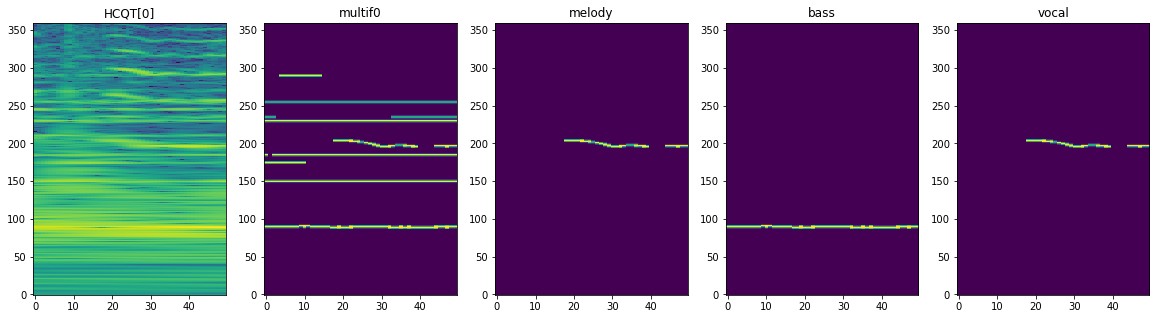

In [101]:
mtask_gen = multitask_generator(mdb.TRACK_LIST_V1 + mdb.TRACK_LIST_V2 + mdb.TRACK_LIST_EXTRA)

In [ ]:
pescador.__version__

In [ ]:
pescador.Mux?